In [1]:
import glob
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
IMG_DIM = (150, 150)
np.random.seed(42)

/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Tommy/opt/anaconda3/e

In [2]:
# load data
# _data_path = './asset2/dog_cat/'
_data_path = '../datasets and figures/asset2/dog_cat/'

train_dir = _data_path+"training_data/"
valid_dir = _data_path+"validation_data/"
test_dir = _data_path+"test_data/"

train_files = glob.glob(train_dir+"*") 
print(len(train_files))
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in train_files]
print(train_imgs.shape)

validation_files = glob.glob(valid_dir+'*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob(test_dir+'*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in test_files]
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,
     '\ttest dataset shape:', test_imgs.shape)

3000
(3000, 150, 150, 3)
Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3) 	test dataset shape: (1000, 150, 150, 3)


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()   #### convert class labels to one-hot code
le.fit(train_labels)   
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)



Using TensorFlow backend.


# VGG16 model
VGG is proposed by the Group of Oxford's Visual Geometry Group. The main work is to prove that increasing the depth of the network can affect the final performance of the network.VGG has two structures, namely VGG16 and VGG19. There is no essential difference between the two, but the network depth is different
Schematic Diagram of VGG16 Model:
<img src="VGG161.jpeg" style="zoom:50%" />


In [11]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
test_imgs_scaled = test_imgs.astype('float32')
train_imgs_scaled /= 255    ### (150,150,3)
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

In [12]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

print(train_labels[0:5], train_labels_enc[0:5])

['', '', '', '', ''] [0 0 0 0 0]


The VGG() class takes a few arguments that may only interest you if you are looking to use the model in your own project, e.g. for transfer learning.

>**include_top (True)**: Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.  
**weights (‘imagenet‘)**: What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.  
**input_tensor (None)**: A new input layer if you intend to fit the model on new data of a different size.  
**input_shape (None)**: The size of images that the model is expected to take if you change the input layer.  
**pooling (None)**: The type of pooling to use when you are training a new set of output layers.  
**classes (1000)**: The number of classes (e.g. size of output vector) for the model.

In [13]:
from keras.applications import vgg16   ################# Important code ####################
from keras.models import Model
import keras


# the VGG16 is pretrained model   ################# call VGG ####################
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  input_shape=input_shape)
# the last layer
output = vgg.layers[-1].output #   the last  layer  before flatten ###################
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)  #########################
vgg_model.trainable = False  #The layer is not trainable  ode #############

for layer in vgg_model.layers:
    layer.trainable = False # each layer is not trainable

vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [14]:
#To show the each layer whether can be trainable.
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x62c0ecc18>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x62c0ecba8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x62c0f4208>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x62c1148d0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x62c114860>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x62769b748>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x6276bbdd8>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x6276d20b8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x62ae89518>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x62aea3630>,block3_conv3,False


(1, 4, 4, 512)


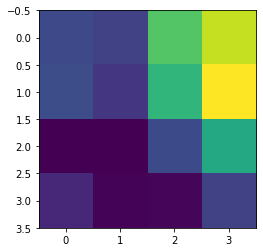

In [15]:
# output the images after VGG before the flatten  layers
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [16]:
# the feature generated by the last layer of VGG16
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled) ### (150,150,3)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)
test_features_vgg = get_bottleneck_features(vgg_model, test_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape,
     '\test Bottleneck Features:', test_features_vgg.shape)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1] ############using the (,8192) as the input size
model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

In [12]:
# To fit the model
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4359 - accuracy: 0.7840 - val_loss: 0.3293 - val_accuracy: 0.8550
Epoch 2/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2907 - accuracy: 0.8737 - val_loss: 0.3303 - val_accuracy: 0.8530
Epoch 3/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2361 - accuracy: 0.9047 - val_loss: 0.3616 - val_accuracy: 0.8530
Epoch 4/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2085 - accuracy: 0.9170 - val_loss: 0.2810 - val_accuracy: 0.8930
Epoch 5/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1743 - accuracy: 0.9260 - val_loss: 0.2735 - val_accuracy: 0.9000
Epoch 6/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1430 - accuracy: 0.9423 - val_loss: 0.5223 - val_accuracy: 0.8280
Epoch 7/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1217 - acc

In [13]:
test1_pre = model.predict(test_features_vgg)
print('\n#Evaluate on the test data')
loss, accuracy = model.evaluate(test_features_vgg,test_labels_enc)
print('loss:%.4f accuracy:%.4f'%(loss,accuracy))


#Evaluate on the test data
1000/1000 [==============================] - 0s 144us/step
loss:0.8021 accuracy:0.9000


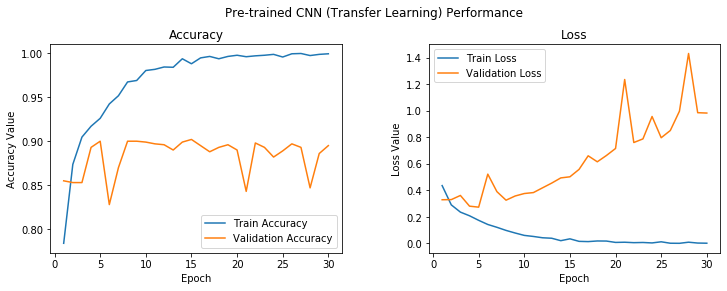

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [15]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

## Data augmentation with Fine-Tuning by VGG16

The above results appear  overfitting (left), so the following exmaple generates new examples to use the same model for traning


In [16]:

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/10
100/100 [==============================] - 104s 1s/step - loss: 0.6427 - accuracy: 0.6167 - val_loss: 0.5623 - val_accuracy: 0.7830
Epoch 2/10
100/100 [==============================] - 104s 1s/step - loss: 0.5423 - accuracy: 0.7273 - val_loss: 0.3065 - val_accuracy: 0.8260
Epoch 3/10
100/100 [==============================] - 103s 1s/step - loss: 0.4996 - accuracy: 0.7597 - val_loss: 0.3519 - val_accuracy: 0.8510
Epoch 4/10
100/100 [==============================] - 102s 1s/step - loss: 0.4657 - accuracy: 0.7807 - val_loss: 0.3000 - val_accuracy: 0.8520
Epoch 5/10
100/100 [==============================] - 102s 1s/step - loss: 0.4542 - accuracy: 0.7840 - val_loss: 0.3438 - val_accuracy: 0.8520
Epoch 6/10
100/100 [==============================] - 103s 1s/step - loss: 0.4274 - accuracy: 0.8007 - val_loss: 0.3808 - val_accuracy: 0.8710
Epoch 7/10
100/100 [==============================] - 102s 1s/step - loss: 0.4171 - accuracy: 0.8047 - val_loss: 0.3497 - val_accuracy: 0.8640

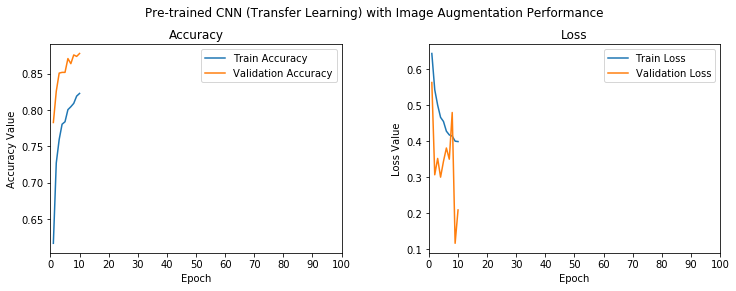

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

## Set The Laster 2 Blocks Trainable


In [21]:
vgg_model.trainable = True  ### make vgg trainable
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.93

In [22]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002889EF4D708>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x00000288403C45C8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002889EF2D988>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x00000288EF857188>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x00000288EF857E48>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x00000288EF862E48>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x00000288EF8603C8>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x00000288EF860248>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x00000288EF870B48>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x00000288EF87A4C8>,block3_conv3,False


In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)  ## both Block 4 and Block 5 trainable
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/10
100/100 [==============================] - 247s 2s/step - loss: 0.5775 - accuracy: 0.6953 - val_loss: 0.5416 - val_accuracy: 0.8410
Epoch 2/10
100/100 [==============================] - 246s 2s/step - loss: 0.4047 - accuracy: 0.8177 - val_loss: 0.1767 - val_accuracy: 0.8940
Epoch 3/10
100/100 [==============================] - 247s 2s/step - loss: 0.3143 - accuracy: 0.8703 - val_loss: 0.2108 - val_accuracy: 0.9220
Epoch 4/10
100/100 [==============================] - 246s 2s/step - loss: 0.2926 - accuracy: 0.8800 - val_loss: 0.1044 - val_accuracy: 0.9400
Epoch 5/10
100/100 [==============================] - 246s 2s/step - loss: 0.2537 - accuracy: 0.8933 - val_loss: 0.1174 - val_accuracy: 0.9340
Epoch 6/10
100/100 [==============================] - 246s 2s/step - loss: 0.2402 - accuracy: 0.9037 - val_loss: 0.0960 - val_accuracy: 0.9420
Epoch 7/10
100/100 [==============================] - 247s 2s/step - loss: 0.2239 - accuracy: 0.9063 - val_loss: 0.3836 - val_accuracy: 0.9450

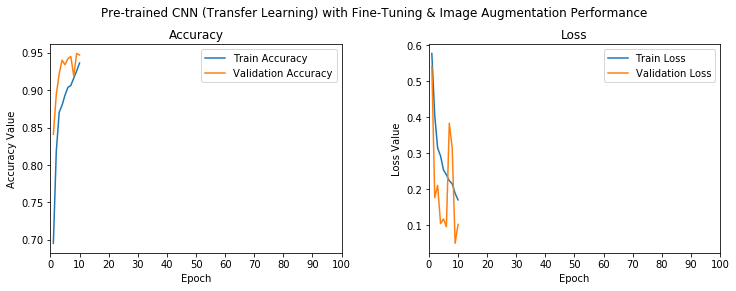

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Ex 1. InceptionV3
The core idea of Inception Module is to extract the information of different scales of images through multiple convolution kernels and finally fuse them to obtain better representation of images.
Schematic Diagram of InceptionV3 Model:

<img src="inceptionv3.png" style="zoom:100%" />

In [29]:
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, InputLayer
from keras import optimizers
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [30]:
input_shape = (150, 150, 3)
inception_base = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

pixel_branch = inception_base.output
pixel_branch = Flatten()(pixel_branch)

new_model_inception = Model(inputs=inception_base.input, outputs=pixel_branch)
new_model_inception.trainable = False

for layer in new_model_inception.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 96s 1us/step


In [31]:
def get_bottle_features(model, input_imgs):   ####################################
    features = model.predict(input_imgs, verbose=0)
    return features


In [32]:
train_features_inception = get_bottle_features(new_model_inception, train_imgs_scaled)
validation_features_inception = get_bottle_features(new_model_inception, validation_imgs_scaled)

In [33]:
input_shape = new_model_inception.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 9,700,865
Trainable params: 9,700,865
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(x=train_features_inception,
                    y=train_labels_enc,
                    validation_data=(validation_features_inception, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.4222 - accuracy: 0.9010 - val_loss: 0.1226 - val_accuracy: 0.9580
Epoch 2/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1849 - accuracy: 0.9527 - val_loss: 0.1918 - val_accuracy: 0.9410
Epoch 3/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1492 - accuracy: 0.9573 - val_loss: 0.4123 - val_accuracy: 0.8930
Epoch 4/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1363 - accuracy: 0.9640 - val_loss: 0.1482 - val_accuracy: 0.9580
Epoch 5/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1298 - accuracy: 0.9687 - val_loss: 0.1781 - val_accuracy: 0.9550
Epoch 6/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0889 - accuracy: 0.9783 - val_loss: 0.2002 - val_accuracy: 0.9550
Epoch 7/30
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0739 - acc

# Ex2. VGG19

In [36]:
from keras.applications.vgg19 import VGG19

In [39]:
IMG_DIM = (150, 150)

train_files = glob.glob('asset2/dog_cat/training_data/*')
# print(train_files)
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
print(train_imgs.shape)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('asset2/dog_cat/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape)



le = LabelEncoder()
le.fit(train_labels)
# encode  labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])


(3000, 150, 150, 3)
Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]


In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [41]:
train_imgs_scaled = train_imgs.astype('float32')

validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)



le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]


In [42]:
VGG19_base = VGG19(input_shape=input_shape, weights='imagenet', include_top=False)

pixel_branch = VGG19_base.output
pixel_branch = Flatten()(pixel_branch)

new_model_vgg19 = Model(inputs=VGG19_base.input, outputs=pixel_branch)
new_model_vgg19.trainable = False

for layer in new_model_vgg19.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 125s 2us/step


In [43]:
train_features_vgg19 = get_bottle_features(new_model_vgg19, train_imgs_scaled)
validation_features_vgg19 = get_bottle_features(new_model_vgg19, validation_imgs_scaled)

In [44]:
input_shape = new_model_vgg19.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(x=train_features_vgg19,
                    y=train_labels_enc,
                    validation_data=(validation_features_vgg19, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4898 - accuracy: 0.7500 - val_loss: 0.3344 - val_accuracy: 0.8560
Epoch 2/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3302 - accuracy: 0.8490 - val_loss: 0.3073 - val_accuracy: 0.8720
Epoch 3/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2852 - accuracy: 0.8730 - val_loss: 0.2914 - val_accuracy: 0.8800
Epoch 4/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2427 - accuracy: 0.8933 - val_loss: 0.3473 - val_accuracy: 0.8460
Epoch 5/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2248 - accuracy: 0.9017 - val_loss: 0.3028 - val_accuracy: 0.8750
Epoch 6/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1880 - accuracy: 0.9267 - val_loss: 0.3431 - val_accuracy: 0.8590
Epoch 7/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1705 - acc

In [48]:
model.predict(validation_features_vgg19)

array([[1.86439469e-01],
       [8.25020671e-01],
       [4.99825510e-05],
       [2.73289551e-11],
       [1.99538770e-14],
       [1.15662132e-13],
       [2.93017047e-06],
       [4.07547937e-13],
       [1.00000000e+00],
       [6.73808972e-05],
       [2.98227185e-08],
       [1.87972654e-02],
       [7.42160133e-04],
       [1.32742055e-11],
       [2.27780352e-15],
       [2.39726418e-04],
       [3.80873166e-06],
       [6.27167263e-10],
       [4.74845976e-01],
       [1.45954999e-07],
       [9.66527581e-01],
       [5.28185789e-19],
       [1.33598915e-13],
       [2.54828632e-02],
       [4.39583578e-11],
       [4.86377208e-03],
       [3.61899330e-11],
       [2.38094510e-13],
       [2.47477114e-01],
       [1.10194455e-15],
       [5.70306741e-03],
       [8.58503336e-06],
       [1.92637695e-03],
       [6.52968645e-01],
       [8.07744345e-06],
       [1.15046115e-03],
       [3.09251696e-17],
       [3.46324441e-06],
       [3.55737033e-12],
       [4.53436106e-01],


# Ex. 3 MobileNet model

In [49]:
from keras.applications.mobilenet import MobileNet

In [50]:
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, InputLayer
from keras import optimizers
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [51]:
IMG_DIM = (150, 150)

train_files = glob.glob('asset2/dog_cat/training_data/*')
# print(train_files)
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
print(train_imgs.shape)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('asset2/dog_cat/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape)
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255


le = LabelEncoder()
le.fit(train_labels)
# encode  labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

(3000, 150, 150, 3)
Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]


In [52]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [53]:
input_shape = (150, 150, 3)
MobileNet_base = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)

pixel_branch = MobileNet_base.output
pixel_branch = Flatten()(pixel_branch)

new_model_MobileNet = Model(inputs=MobileNet_base.input, outputs=pixel_branch)
new_model_MobileNet.trainable = False

for layer in new_model_MobileNet.layers:
    layer.trainable = False

C:\Users\xzhu2\Documents\ProgramData\anaconda3\envs\AML158736\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [54]:
train_features_MobileNet = get_bottle_features(new_model_MobileNet, train_imgs_scaled)
validation_features_MobileNet = get_bottle_features(new_model_MobileNet, validation_imgs_scaled)

In [55]:
input_shape = new_model_MobileNet.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 8,652,289
Trainable params: 8,652,289
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(x=train_features_MobileNet,
                    y=train_labels_enc,
                    validation_data=(validation_features_MobileNet, validation_labels_enc),
                    batch_size=50,
                    epochs=30,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4014 - accuracy: 0.9007 - val_loss: 0.0962 - val_accuracy: 0.9650
Epoch 2/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0876 - accuracy: 0.9620 - val_loss: 0.1211 - val_accuracy: 0.9570
Epoch 3/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0543 - accuracy: 0.9813 - val_loss: 0.2288 - val_accuracy: 0.9480
Epoch 4/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.2877 - val_accuracy: 0.9430
Epoch 5/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0408 - accuracy: 0.9900 - val_loss: 0.1623 - val_accuracy: 0.9660
Epoch 6/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0288 - accuracy: 0.9943 - val_loss: 0.2215 - val_accuracy: 0.9610
Epoch 7/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0222 - acc

In [58]:
model.predict(validation_features_MobileNet)

array([[1.02076428e-02],
       [1.29776805e-13],
       [1.53186935e-19],
       [1.26589328e-24],
       [2.28336388e-29],
       [1.16392216e-28],
       [1.50392907e-30],
       [2.37297001e-32],
       [3.47947402e-27],
       [4.78492386e-18],
       [6.86860327e-21],
       [1.83596097e-20],
       [6.05914630e-02],
       [4.42006851e-25],
       [2.11863032e-24],
       [4.46065785e-23],
       [3.98034592e-26],
       [7.24920965e-22],
       [2.19623192e-15],
       [8.09282407e-28],
       [9.10590430e-08],
       [0.00000000e+00],
       [1.06653945e-29],
       [1.39133601e-06],
       [4.50308267e-27],
       [8.20150526e-28],
       [2.94615823e-29],
       [2.69231185e-34],
       [3.94142378e-04],
       [1.02821620e-28],
       [9.46793795e-01],
       [1.43426636e-29],
       [3.91960639e-12],
       [1.14445928e-02],
       [2.35727925e-33],
       [9.36949967e-14],
       [4.91065838e-22],
       [1.44011688e-28],
       [1.27287468e-26],
       [8.80469644e-30],
